<center><font size="+4">Programming & Data Analytics & AI 2 PM 2024/2025</font></center>
<center><font size="+2">Sant'Anna School of Advanced Studies, Pisa, Italy</font></center>
<center><img src="https://github.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/raw/main/PDAI/jupyter/jupyterNotebooks/images/sssaLEMBEDSdtu.png" width="900" alt="L'EMbeDS"></center>

<center><font size="+2">Course responsible</font></center>
<center><font size="+2">Andrea Vandin a.vandin@santannapisa.it</font></center>

---

<center><font size="+2">Notebook for Class 8 </font></center>
<center><font size="+2"> Conformance Checking. Data lab
</font></center>

---
---

In [3]:
url_github_repo="https://github.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/raw/main/PDAI/"

pm_slides=url_github_repo+'jupyter/jupyterNotebooks/images/PM/'
from IPython.display import Image, display

For an informed discussion on this topic, I recommend you watching classes of Module 3 of the [Coursera course on PM](https://www.coursera.org/learn/process-mining/home/welcome)
- https://www.coursera.org/learn/process-mining/home/module/3



> Below we provide screenshots from some slides used above

# Overview

Often, one wants to compare an event log with
- A reference (or normative) model
- A mined model

This is done to
- understand whether the expected behavior actually occurs
- identify and analyze deviations
  - These _outliers_ are often the  _interesting cases_
    - some may be good (doctors deviate to save the life of a specific patient)
    - some may be bad (an office forgets performing a quality  check before sending money out)

During the classes on pm4py we studied two approaches to conformance checking
- token-based 
  - tells us how much each trace and all logs conform to a model (it counts missing and remaining tokens)
- alignment-based
  1. tells us how much each trace and all logs conform to a model
  2. tells us how to modify the model or traces to make the model conformant


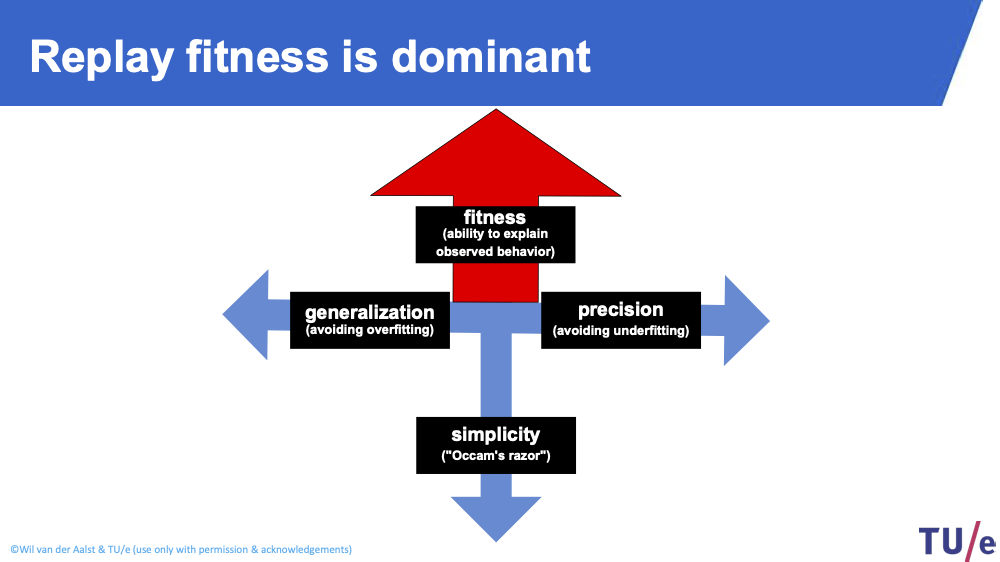

In [4]:
img=Image(pm_slides+'confFitness.png',width=700)
display(img)

# Conformance checking based on Causal footprints

# Conformance checking based on Token-based replay 

# Conformance checking based on Alignment